# Machine Learning Modelle
1. [Entfernen von zukunftsbezogenen Features](#1)
1. [Multiple Lineare Regression](#2)
1. [Random Forest](#3)
1. [XGBoost](#4)
  1. [Permutation Importance](#5)
  1. [F-Score](#6)
  1. [SHAP Values](#7)
1. [Performance-Vergleich](#8)

In [1]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.5 MB/s eta 0:00:00
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/95/3c/c58057dde22b0280f3e07a68b681ca70ab7adc6cdaf5b0396277bfe3142b/statsforecast-1.7.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
  Obtaining dependency information

In [25]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mae, rmse, mape

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

ONE_DAY = 24
ONE_WEEK = ONE_DAY * 7

LAGS = [1, 2, 3, ONE_DAY, 2*ONE_DAY, 3*ONE_DAY]
D_LAGS = [number * -1 for number in LAGS]

PAST_COV = ['outdoor_temp', 'app_outdoor_temp', 'humidity', 'air', 'bathroom', 'car', 'clotheswasher', 'dishwasher', 'drye',
            'dryg', 'furnace', 'kitchenapp', 'livingroom', 'microwave', 'oven', 'refrigerator', 'utilityroom', 'venthood']
FUTURE_COV = ['is_holiday', 'hour', 'wday', 'day', 'month', 'is_off_day', 'arima_preds', 'arima_preds_x', 'es_preds', 'prophet_preds']

FUTURE_LAGS = [0, 1, 2, 3]
PAST_LAGS = ONE_WEEK - len(FUTURE_LAGS) - 1

print("Setup complete")

Setup complete


In [3]:
df = pd.read_csv("../input/ps-ds3-new/ps_ds3.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)

# Erste Woche auslassen, da hierfür keine Benchmark Vorhersagen existieren
df = df[ONE_WEEK:]

df.head()

,use,outdoor_temp,app_outdoor_temp,humidity,is_holiday,hour,wday,day,month,is_off_day,...,livingroom,microwave,oven,refrigerator,utilityroom,venthood,arima_preds,arima_preds_x,es_preds,prophet_preds
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,0.34850,13.21,13.21,0.75,False,0,0,8,1,False,...,NaN,NaN,0.008,NaN,NaN,NaN,0.609486,0.609486,0.220875,0.625086
2018-01-08 01:00:00,0.33400,12.36,12.36,0.66,False,1,0,8,1,False,...,NaN,NaN,0.008,NaN,NaN,NaN,0.707786,0.707786,0.145688,0.565375
2018-01-08 02:00:00,0.24725,11.92,11.92,0.64,False,2,0,8,1,False,...,NaN,NaN,0.008,NaN,NaN,NaN,0.765565,0.765565,-0.023472,0.343196
2018-01-08 03:00:00,0.34775,11.33,11.33,0.66,False,3,0,8,1,False,...,NaN,NaN,0.008,NaN,NaN,NaN,0.799528,0.799528,0.005394,0.399465
2018-01-08 04:00:00,0.31900,10.86,10.86,0.61,False,4,0,8,1,False,...,NaN,NaN,0.008,NaN,NaN,NaN,0.819490,0.819490,0.017725,0.515787


In [4]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100
sorted_missing_share = missing_share.sort_values(ascending=False)

max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in sorted_missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

dishwasher      	2.58%
venthood        	2.58%
utilityroom     	2.58%
refrigerator    	2.58%
microwave       	2.58%
livingroom      	2.58%
kitchenapp      	2.58%
furnace         	2.58%
bathroom        	2.58%
clotheswasher   	2.58%
dryg            	2.58%
drye            	1.66%
oven            	1.66%
air             	1.66%
car             	1.66%
use             	1.14%
outdoor_temp    	0.02%
humidity        	0.02%
app_outdoor_temp	0.02%


In [5]:
# Manuelle Imputation, da für TimeSeries.from_series() nur ein konstanter Füllwert festgelegt werden könnte
float_columns = df.select_dtypes(include=['float64']).columns

for column in float_columns:
    if df[column].head(ONE_WEEK).isna().all():
        train_avg = 0
    else:
        train_avg = df[column].head(ONE_WEEK).median()
    df[column] = df[column].fillna(train_avg)

series = TimeSeries.from_series(df, freq='h')

In [92]:
def predict_daily(series, model, use_cov=True):
    """
    Erstellt eine Vorhersage für die bereitgestellten Daten mit dem angegebenen Modell.
    :param df: Ein Dataframe, der einen Zeitstempel und eine Spalte 'use' mit realen Messwerten enthält.
    :param model: Ein angepasstes Modell aus der darts Bibliothek.
    :return: Eine Liste aller Vorhersagen für das entsprechende Modell.
    """
    if use_cov:
        historical_forecast = model.historical_forecasts(
            series=series['use'],
            past_covariates=series[PAST_COV],
            future_covariates=series[FUTURE_COV],
            train_length=ONE_WEEK,
            forecast_horizon=ONE_DAY,
            last_points_only=False,
            stride=ONE_DAY,
            verbose=True
        )
    else:
        historical_forecast = model.historical_forecasts(
            series=series['use'],
            train_length=ONE_WEEK,
            forecast_horizon=ONE_DAY,
            last_points_only=False,
            stride=ONE_DAY,
            verbose=True
        )
    
    comb_df = pd.DataFrame()
    
    for fold in historical_forecast:
        preds = fold.pd_dataframe()
        comb_df = pd.concat([comb_df, preds])
    
    return comb_df


def eval_model(df, model_str):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten und gibt diese in der Konsole aus.
    :param df: Ein Dataframe, der eine Spalte 'use' mit tatsächlichen Messwerten und
               eine Spalte mit vorhergesagten Werten für das entsprechende Modell enthält.
    :param model_str: Der Name der Spalte für die vorhergesagten Werte.
    """
    # In darts TimeSeries Objekte konvertieren
    actual = TimeSeries.from_values(df['use'])
    predicted = TimeSeries.from_values(df[model_str])
    
    avg_mae = round(mae(actual, predicted), 2)
    avg_rmse = round(rmse(actual, predicted), 2)
    
    try:
        avg_mape = round(mape(actual, predicted), 2)
        negative_vals = None
    except ValueError as e:
        df_filtered = df[(df['use'] > 0) & (df[model_str] > 0)]
        actual = TimeSeries.from_values(df_filtered['use'])
        predicted = TimeSeries.from_values(df_filtered[model_str])
        avg_mape = round(mape(actual, predicted), 2)
        negative_vals = f"[ERROR] {e}\n"
    
    print(f"MAE: {avg_mae}, RMSE: {avg_rmse}, MAPE: {avg_mape} %")
    if negative_vals:
        print(negative_vals)

In [7]:
df_save = df.copy()

<a id="3"></a>
## 3. Multiple Lineare Regression

In [8]:
from darts.models import LinearRegressionModel

lr_model = LinearRegressionModel(
    lags=D_LAGS,
    lags_past_covariates=PAST_LAGS,
    lags_future_covariates=FUTURE_LAGS
)

lr_str = "lr_preds"
df_save[lr_str] = predict_daily(series, lr_model)
eval_model(df_save, lr_str)

  0%|          | 0/351 [00:00<?, ?it/s]

MAE: 1.12, RMSE: 1.53, MAPE: 118.46 %
[ERROR] The actual series must be strictly positive to compute the MAPE.



In [9]:
# WOF = without features

lr_model_wof = LinearRegressionModel(lags=D_LAGS)

lr_str_wof = "lr_preds_wof"
df_save[lr_str_wof] = predict_daily(series, lr_model_wof, False)
eval_model(df_save, lr_str_wof)

  0%|          | 0/351 [00:00<?, ?it/s]

MAE: 0.76, RMSE: 1.12, MAPE: 73.77 %
[ERROR] The actual series must be strictly positive to compute the MAPE.



<a id="4"></a>
## 4. Random Forest
"Für das systematische Tuning können Sie GridSearchCV oder RandomizedSearchCV aus Scikit-Learn verwenden."

In [10]:
# Anzahl der Bäume im Wald
n_estimators = np.arange(100, 1000, 100)
# Anzahl der Features, die bei der Suche nach dem besten Split berücksichtigt werden sollen
max_features = [None, 'sqrt', 'log2']
# Maximale Tiefe der Bäume
max_depth = np.arange(10, 100, 10)
# Minimale Anzahl von Samples, die benötigt werden, um einen internen Knoten zu teilen
min_samples_split = np.arange(2, 10, 1)
# Minimale Anzahl von Samples, die ein Blattknoten haben muss
min_samples_leaf = np.arange(1, 10, 1)
# Ob Bootstrap-Proben beim Aufbau der Bäume verwendet werden sollen
bootstrap = [True, False]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}

In [11]:
# best_model, best_params, _ = RandomForest.gridsearch(
#     parameters=rf_grid,
#     series=series['use'],
#     past_covariates=series[PAST_COV],
#     future_covariates=series[FUTURE_COV],
#     forecast_horizon=ONE_DAY,
#     last_points_only=False,
#     stride=ONE_DAY,
#     metric=rmse,
#     verbose=True
# )

n_param_combs = len(n_estimators) * len(max_features) * len(max_depth) * len(min_samples_split) * len(min_samples_leaf) * len(bootstrap)
print(f"Um das optimale Modell zu finden, müssen {n_param_combs} Parameterkombinationen getestet werden")

Um das optimale Modell zu finden, müssen 34992 Parameterkombinationen getestet werden


#### Da die gridsearch() Methode aus der darts Bibliothek keine randomisierte Suche unterstützt und für dieses Modell eine Berechnungszeit von mehreren Tagen hätte, wird das optimale Modell mit RandomizedSeachCV aus der sklearn Bibliothek ermittelt. Außerdem wird nur eine auswählte Woche betrachtet, um die lokal optimalen Modellparamter zu finden

# Alternativ: erste Woche oder alle Daten?

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

offset = 11
train_data = df[ONE_WEEK*offset:ONE_WEEK*(offset+1)]
train_y = train_data.use
train_X = train_data.drop('use', axis=1)

rf_rsearch = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_grid, n_jobs=-1)
rf_rsearch.fit(train_X, train_y)
best_rf_params = rf_rsearch.best_params_

best_rf_params

{'n_estimators': 900,
 'min_samples_split': 9,
 'min_samples_leaf': 7,
 'max_features': None,
 'max_depth': 30,
 'bootstrap': True}

In [13]:
from darts.models import RandomForest

rf_model = RandomForest(
    lags=D_LAGS,
    lags_past_covariates=PAST_LAGS,
    lags_future_covariates=FUTURE_LAGS,
    **best_rf_params
)

rf_str = "rf_preds"
df_save[rf_str] = predict_daily(series, rf_model)
eval_model(df_save, rf_str)

  0%|          | 0/351 [00:00<?, ?it/s]

MAE: 0.71, RMSE: 1.03, MAPE: 74.3 %
[ERROR] The actual series must be strictly positive to compute the MAPE.



<a id="5"></a>
## 5. XGBoost
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [14]:
xgb_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500, 1000],
    'max_depth': [3, 5, 10, 15],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

In [15]:
from xgboost import XGBRegressor

xgb_rsearch = RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=xgb_grid, n_jobs=-1)
xgb_rsearch.fit(train_X, train_y)
best_xgb_params = xgb_rsearch.best_params_

best_xgb_params

{'subsample': 0.8,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [16]:
from darts.models import XGBModel

xgb_model = XGBModel(
    lags=D_LAGS,
    lags_past_covariates=PAST_LAGS,
    lags_future_covariates=FUTURE_LAGS,
    **best_xgb_params
)

xgb_str = "xgb_preds"
df_save[xgb_str] = predict_daily(series, xgb_model)
eval_model(df_save, xgb_str)

  0%|          | 0/351 [00:00<?, ?it/s]

MAE: 0.76, RMSE: 1.1, MAPE: 79.38 %
[ERROR] The actual series must be strictly positive to compute the MAPE.



In [17]:
def add_lag_features(df, columns):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die angegebenen Spalten hinzu. 
    Für jede Spalte in 'columns' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um eine Stunde.

    :param df: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param columns: Liste der Spaltennamen, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = df.copy()
    for column in columns:
        lagged_df[f'{column}_lag_1'] = lagged_df[column].shift(1)
    return lagged_df


def add_use_lags(df, lag_hours):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die Spalten 'use' hinzu. 
    Für jeden Verzögerungswert in 'lag_hours' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um X Stunden.

    :param df: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param lag_hours: Liste der Verzögerungswerte, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = df.copy()
    for lag in lag_hours:
        lagged_df[f'use_lag_{lag}'] = lagged_df.use.shift(lag)
    return lagged_df

In [18]:
# Verzögerungs-Features hinzufügen und zukunftsbezogene Features entfernen, um Data Leakage zu verhindern
df = add_lag_features(df, PAST_COV)
df.drop(PAST_COV, axis=1, inplace=True)

# Verzögerungs-Features für Spalte use für relevante Zeiten aus der Vergangenheit (nur für use, da sonst zu viele Features)
df = add_use_lags(df, LAGS)

In [93]:
forecast_length = ONE_WEEK + ONE_DAY
test_end = 0
offset = 1
test_xgb_df = pd.DataFrame()

while test_end + forecast_length < len(df):
    print(f"Week {offset}:")
    
    train_start = ONE_WEEK * offset
    train_end = ONE_WEEK * (offset + 1)
    test_end = train_end + ONE_DAY
    train_data = df[train_start:train_end]
    test_data = df[train_end:test_end]
    
    train_y = train_data.use
    train_X = train_data.drop('use', axis=1)
    test_y = test_data.use
    test_X = test_data.drop('use', axis=1)
    
    test_xgb_model = XGBRegressor(early_stopping_rounds=20, **best_xgb_params)
    test_xgb_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (test_X, test_y)])
    xgb_predictions = test_xgb_model.predict(test_X)
    
    temp_df = pd.DataFrame(test_y)
    temp_df['xgb_preds'] = xgb_predictions
    test_xgb_df = pd.concat([test_xgb_df, temp_df])
    
    offset += 1

eval_model(test_xgb_df, 'xgb_preds')

Week 1:
[0]	validation_0-rmse:0.89442	validation_1-rmse:0.58881
[1]	validation_0-rmse:0.75734	validation_1-rmse:0.59353
[2]	validation_0-rmse:0.65039	validation_1-rmse:0.59443
[3]	validation_0-rmse:0.55811	validation_1-rmse:0.62515
[4]	validation_0-rmse:0.47953	validation_1-rmse:0.67568
[5]	validation_0-rmse:0.41870	validation_1-rmse:0.68515
[6]	validation_0-rmse:0.36940	validation_1-rmse:0.73223
[7]	validation_0-rmse:0.32707	validation_1-rmse:0.74755
[8]	validation_0-rmse:0.28255	validation_1-rmse:0.77053
[9]	validation_0-rmse:0.25920	validation_1-rmse:0.77461
[10]	validation_0-rmse:0.22499	validation_1-rmse:0.77048
[11]	validation_0-rmse:0.19610	validation_1-rmse:0.79755
[12]	validation_0-rmse:0.17476	validation_1-rmse:0.79989
[13]	validation_0-rmse:0.15421	validation_1-rmse:0.79090
[14]	validation_0-rmse:0.13681	validation_1-rmse:0.79838
[15]	validation_0-rmse:0.12244	validation_1-rmse:0.79943
[16]	validation_0-rmse:0.11485	validation_1-rmse:0.80065
[17]	validation_0-rmse:0.10862	va

# Overfitting Plot

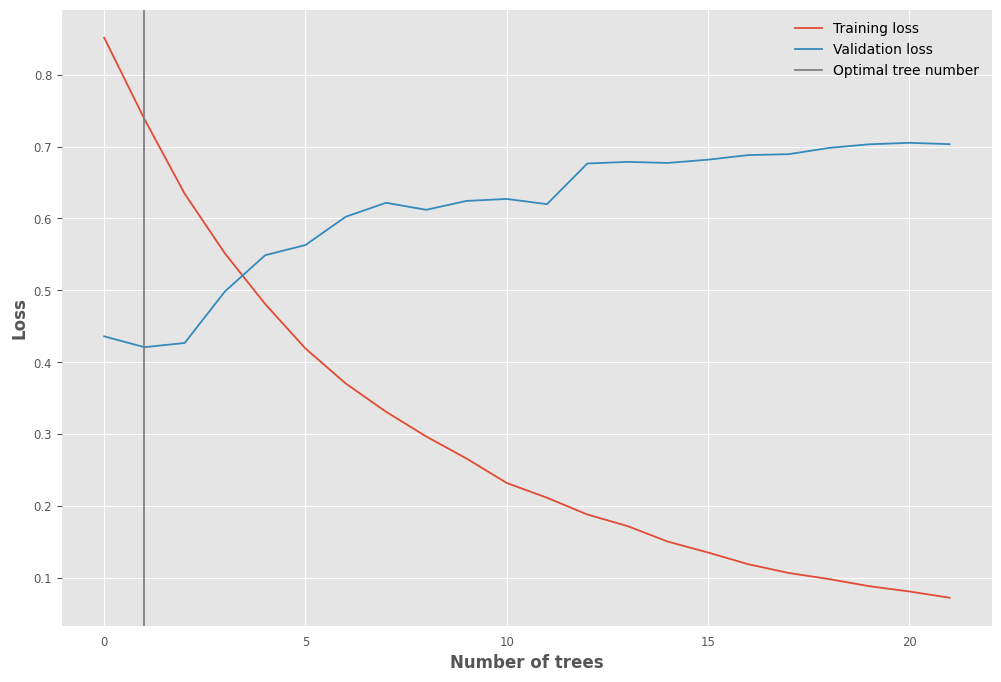

In [94]:
optimal_trees = test_xgb_model.best_iteration
results = test_xgb_model.evals_result()

plt.figure(figsize=(12, 8))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(optimal_trees, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

# Ohne early_stopping_rounds

<a id="6"></a>
## 5.1 Permutation Importance
https://www.kaggle.com/code/dansbecker/permutation-importance

In [95]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(test_xgb_model).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=test_X.columns.tolist())

Weight,Feature
0.2846 ± 0.1855,bathroom_lag_1
0.1444 ± 0.0474,refrigerator_lag_1
0.0770 ± 0.1025,venthood_lag_1
0.0635 ± 0.0372,microwave_lag_1
0.0471 ± 0.0339,use_lag_24
0.0384 ± 0.0940,use_lag_72
0.0227 ± 0.0463,hour
0.0157 ± 0.0206,app_outdoor_temp_lag_1
0.0118 ± 0.0131,dryg_lag_1
0.0118 ± 0.0207,kitchenapp_lag_1


<a id="7"></a>
## 5.2 F-Score

Nein, der F-Score, der aus einer Methode wie .get_fscore() (typischerweise in Bibliotheken wie XGBoost verwendet) und die Feature-Importance, die durch Permutationswichtigkeit (Permutation Importance) ermittelt wird, sind nicht dasselbe. Sie basieren auf unterschiedlichen Methoden zur Bestimmung der Wichtigkeit von Features.

F-Score aus .get_fscore() in XGBoost oder ähnlichen Bibliotheken:

Dieser basiert in der Regel auf der Anzahl der Male, dass ein Feature beim Aufbau der Bäume im Modell verwendet wird.
In Entscheidungsbaum-basierten Modellen wie XGBoost bedeutet ein höherer F-Score, dass das Feature häufiger verwendet wird, um die Bäume zu teilen, was auf eine höhere Wichtigkeit hindeutet.
Dies ist eine intrinsische Methode, die direkt aus dem Trainingsprozess des Modells stammt.
Permutationswichtigkeit (Permutation Importance):

Bei der Permutationswichtigkeit wird die Wichtigkeit eines Features durch das Mischen (Permutieren) der Werte dieses Features über die Beobachtungen hinweg und das Beobachten der Aus
wirkungen auf die Modellleistung ermittelt.

Wenn die Permutation eines Features zu einer erheblichen Verschlechterung der Modellleistung führt, deutet dies darauf hin, dass das Feature wichtig ist.
Diese Methode ist modellagnostisch, was bedeutet, dass sie unabhängig vom verwendeten Modelltyp funktioniert. Sie misst den Einfluss eines Features auf die Vorhersagegenauigkeit des Modells.
Der Hauptunterschied zwischen diesen beiden Methoden liegt in ihrer Herangehensweise:

Der F-Score gibt an, wie oft ein Feature beim Aufbau der Bäume eines Entscheidungsbaummodells verwendet wurde. Es ist eine direktere Messung basierend auf dem Trainingsprozess des Modells.
Die Permutationswichtigkeit misst, wie sich die Vorhersageleistung des Modells ändert, wenn die Werte eines Features zufällig geändert werden. Sie gibt Aufschluss darüber, wie sich die Unordnung eines Features auf die Genauigkeit des Modells auswirkt.
Beide Methoden können nützliche Einblicke in die Wichtigkeit von Features geben, aber sie können unterschiedliche Ergebnisse liefern, je nach den Eigenschaften der Daten und des Modells. In der Praxis ist es oft sinnvoll, beide Methoden zu verwenden, um ein umfassenderes Bild der Feature-Wichtigkeit zu erhalten.

Beispiel: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

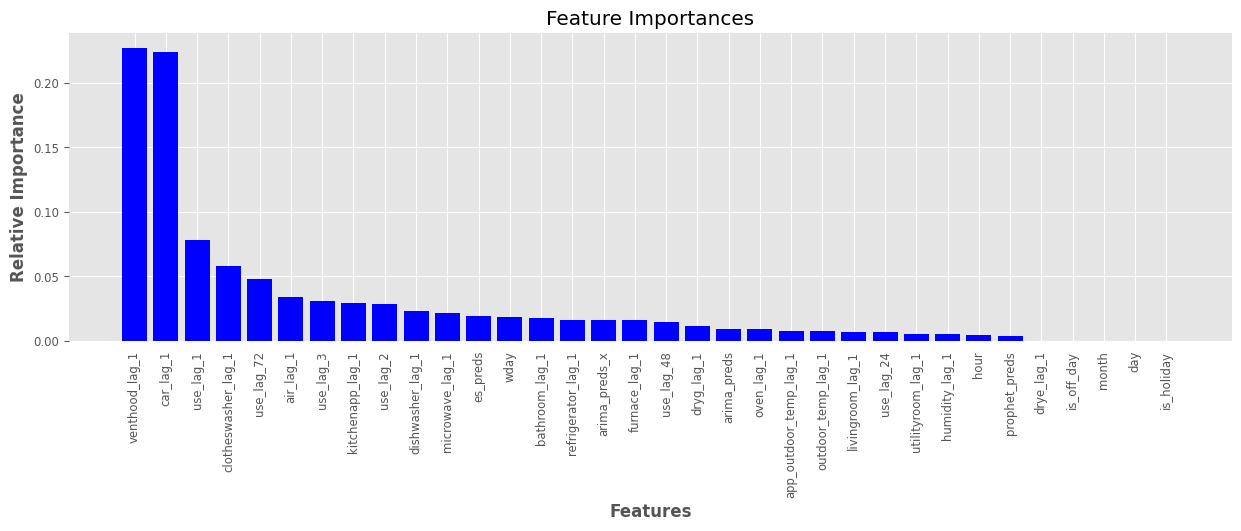

In [96]:
# Feature Labels
feature_labels = train_X.columns

# Extrahieren der Feature-Importances
feature_importances = test_xgb_model.feature_importances_

# Überprüfen, ob die Anzahl der Features übereinstimmt
if len(feature_labels) != len(feature_importances):
    raise ValueError("Die Anzahl der Features im Modell stimmt nicht mit der Anzahl der ursprünglichen Features überein.")
    
# Zuordnung der Feature-Namen
importance_df = pd.DataFrame({'feature': feature_labels, 'importance': feature_importances})
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Erstellen des Plots
plt.figure(figsize=(15, 4))
plt.title("Feature Importances")
plt.bar(importance_df.feature, importance_df.importance, color='b')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

<a id="8"></a>
## 5.3 SHAP Values
* https://www.kaggle.com/code/dansbecker/shap-values
* https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values

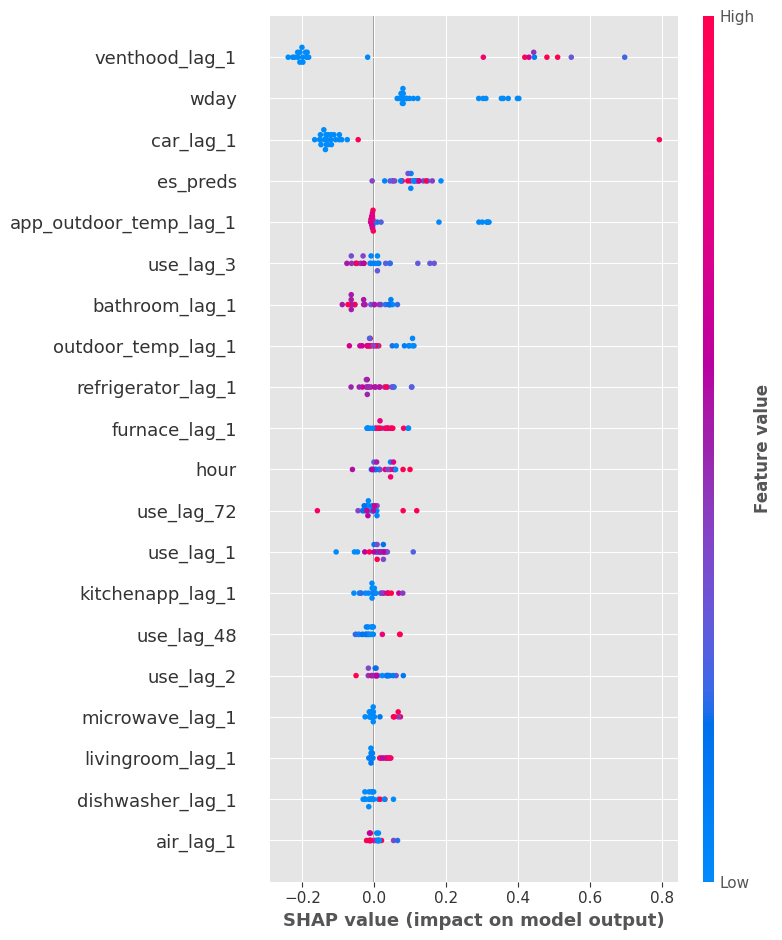

In [97]:
import shap

explainer = shap.TreeExplainer(test_xgb_model)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

Interpretation:
* Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.

Wenn use_lag_1 einen hohen Wert hat, wird ein hoher Verbrauch vorhergesagt.

Wenn use_lag_2 einen hohen Wert hat, wird ein niedriger Verbrauch vorhergesagt.

<a id="9"></a>
## 6. Performance-Vergleich

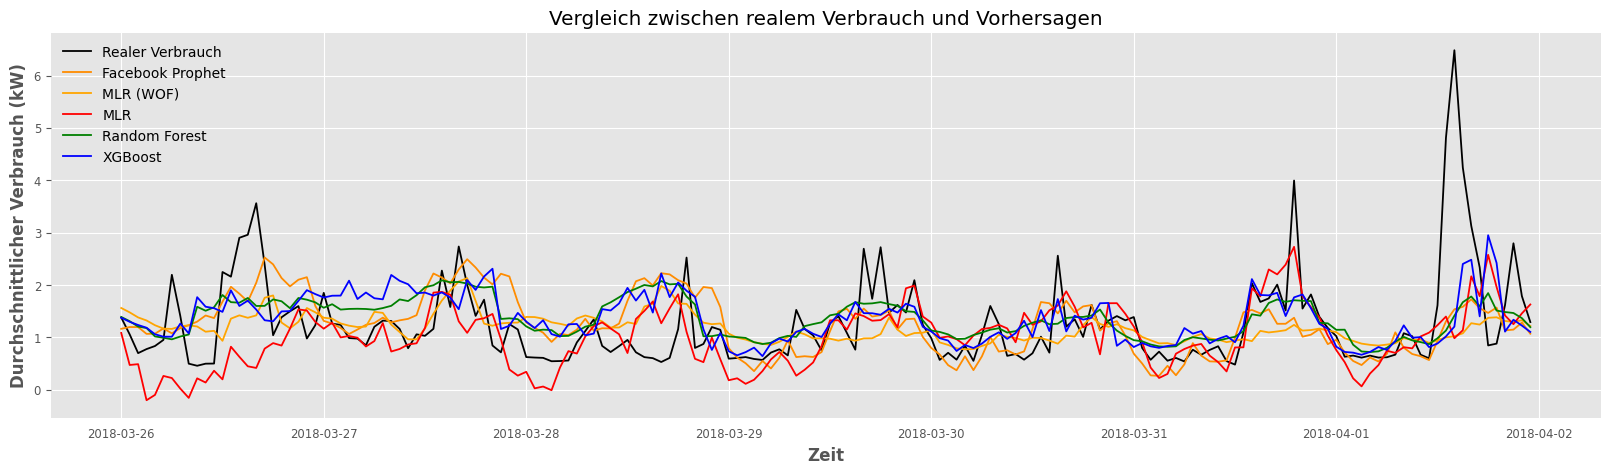

In [98]:
offset = 11
df_plot = df_save[ONE_WEEK*offset:ONE_WEEK*(offset+1)]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.use, color='black', label='Realer Verbrauch')
plt.plot(df_plot.index, df_plot.prophet_preds, color='darkorange', label='Facebook Prophet')
plt.plot(df_plot.index, df_plot.lr_preds_wof, color='orange', label='MLR (WOF)')
plt.plot(df_plot.index, df_plot.lr_preds, color='red', label='MLR')
plt.plot(df_plot.index, df_plot.rf_preds, color='green', label='Random Forest')
plt.plot(df_plot.index, df_plot.xgb_preds, color='blue', label='XGBoost')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.legend()
plt.show()